#### Transfer Learning for Multilabel
- Backbone VGG-16
- Images cropped and resized
- VGG 16 Paper preprocessing as done in Paper for Network: https://arxiv.org/abs/1409.1556
- Recall for Validation
- Resolve issue with generator

Sources for issue resuolution:
- https://github.com/keras-team/keras/issues/741
- https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [3]:
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout


In [4]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow import keras


In [5]:
data = pd.read_csv('/content/drive/MyDrive/Multilabel/multilabel4.csv')

In [6]:
data.head()

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal,new
0,3f58d128caf6.jpg,0,0,1,0,0,0,0,glaucoma
1,4ce6599e7b20.jpg,1,0,0,0,1,0,0,"opacity, macular degeneration"
2,0def470360e4.jpg,1,0,0,0,1,0,0,"opacity, macular degeneration"
3,802b4bfabd52.jpg,0,0,0,0,1,0,0,macular degeneration
4,7bcfab1fa2da.jpg,1,0,0,0,0,0,0,opacity


In [7]:
data.shape

(2399, 9)

In [8]:
df = data[['filename', 'opacity', 'glaucoma', 'macular degeneration', 'normal']]

In [9]:
df.head()

,filename,opacity,glaucoma,macular degeneration,normal
0,3f58d128caf6.jpg,0,1,0,0
1,4ce6599e7b20.jpg,1,0,1,0
2,0def470360e4.jpg,1,0,1,0
3,802b4bfabd52.jpg,0,0,1,0
4,7bcfab1fa2da.jpg,1,0,0,0


In [10]:
cols = df.columns[1:]
cols

Index(['opacity', 'glaucoma', 'macular degeneration', 'normal'], dtype='object')

In [11]:
# Original Images
in_dir = '/content/drive/MyDrive/Multilabel/train_multilabel4'

### Image Generator

In [12]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split = 0.25)

In [13]:
train_gen = datagen.flow_from_dataframe(dataframe = df, 
                                        directory = in_dir, 
                                        x_col = "filename", 
                                        y_col = cols,
                                        batch_size = 32, 
                                        seed = 2, 
                                        shuffle = True, 
                                        class_mode = 'raw', 
                                        subset='training',
                                        target_size = (224,224))

Found 1800 validated image filenames.


In [14]:
val_gen = datagen.flow_from_dataframe(dataframe = df, 
                                     directory = in_dir, 
                                     x_col = "filename", 
                                     y_col = cols,
                                     batch_size = 32, 
                                     seed = 2, 
                                     shuffle = True, 
                                     class_mode = 'raw', 
                                     subset='validation',
                                     target_size = (224,224))

Found 599 validated image filenames.


In [15]:
imgs, labels = next(train_gen)

In [16]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


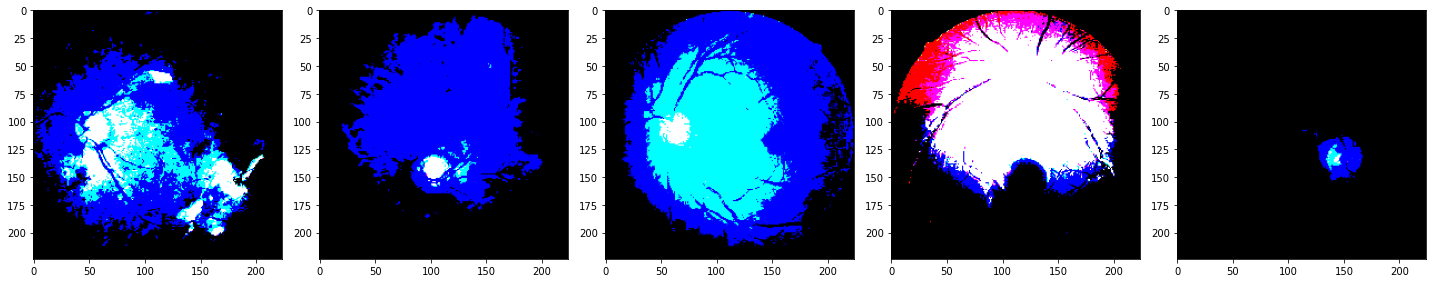

In [17]:
plotImages(imgs)

### Model

In [18]:
model_vgg16 = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 3s 0us/step


In [19]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
model = Sequential()
for layer in model_vgg16.layers[:-1]:
    model.add(layer)

In [21]:
for layer in model.layers:
    layer.trainable = False

In [22]:
model.add(Dense(units=4, activation='sigmoid'))

In [23]:
step_size_train = train_gen.n//train_gen.batch_size
step_size_val = val_gen.n//val_gen.batch_size

In [24]:
lr_reduce = ReduceLROnPlateau(monitor='val_recall', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint = ModelCheckpoint('vgg16_finetune.h15', monitor= 'val_recall', mode= 'max', save_best_only = True, verbose= 1)

In [25]:
model.compile(optimizer=Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['Recall'])

In [26]:
history = model.fit(x=train_gen, validation_data=val_gen, steps_per_epoch=step_size_train, 
          validation_steps=step_size_val, epochs=20, callbacks=[lr_reduce,checkpoint], verbose=2)

Epoch 1/20
56/56 - 728s - loss: 1.6389 - recall: 0.4755 - val_loss: 1.7031 - val_recall: 0.7547

Epoch 00001: val_recall improved from -inf to 0.75472, saving model to vgg16_finetune.h15
INFO:tensorflow:Assets written to: vgg16_finetune.h15/assets
Epoch 2/20
56/56 - 16s - loss: 1.2978 - recall: 0.9505 - val_loss: 1.5400 - val_recall: 1.0000

Epoch 00002: val_recall improved from 0.75472 to 1.00000, saving model to vgg16_finetune.h15
INFO:tensorflow:Assets written to: vgg16_finetune.h15/assets
Epoch 3/20
56/56 - 15s - loss: 1.1601 - recall: 1.0000 - val_loss: 1.5982 - val_recall: 1.0000

Epoch 00003: val_recall did not improve from 1.00000
Epoch 4/20
56/56 - 15s - loss: 1.0854 - recall: 1.0000 - val_loss: 1.5304 - val_recall: 1.0000

Epoch 00004: val_recall did not improve from 1.00000
Epoch 5/20
56/56 - 16s - loss: 1.0418 - recall: 1.0000 - val_loss: 1.4984 - val_recall: 1.0000

Epoch 00005: val_recall did not improve from 1.00000
Epoch 6/20
56/56 - 16s - loss: 1.0087 - recall: 1.0000 

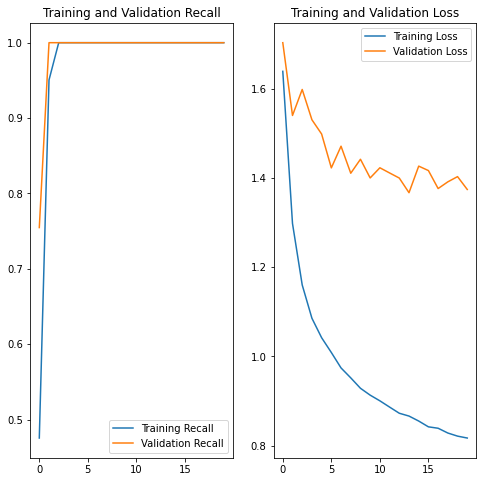

In [27]:
rec = history.history['recall']
val_rec = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rec, label='Training Recall')
plt.plot(epochs_range, val_rec, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()